## Задача № 3. Поиск наилучшей тяги задних колес для наискорейшего прохождения отрезка прямой

Для произвольно выбранного постоянного значения $\mu$ рассматривается задача поиска такой тяги задних колес $F_{x}^{max}$, которая бы обеспечила наискорейшее прохождения отрезка прямой.

Решения состоит из следующих этапов:

1. Инициализировать динамическую модель, выбрав из некоторого допустимого диапазона постоянное значение параметра $\mu$.

2. Вектор управления определить в виде: ```inputForceFL, inputForceFR, inputForceRL, inputForceRR, steer = [0, 0, action, action, 0]```, где `action` $\equiv F_{x}$ и при этом `0 < action < 25`.

3. С помощью алгоритма кросс-энтропии определить $F_{x}^{max}$, обеспечивающий максимизацию дискретного функционала вида $J = - \sum{\Delta T} \to max$.

In [23]:
import numpy as np
import torch.nn as nn
from Agents.CCEM import CCEM
from Agents.Utilities.SequentialNetwork import SequentialNetwork
from Agents.Utilities.Noises import UniformNoise
from Solvers import OneAgentSolver as solver
from Environments.ArrivalCar.ArrivalCarSpeed import ArrivalCarSpeed
from Environments.ArrivalCar.ArrivalCarVisualizer import ArrivalCarVisualizer
from Environments.ArrivalCar.ArrivalCar import ArrivalCar
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


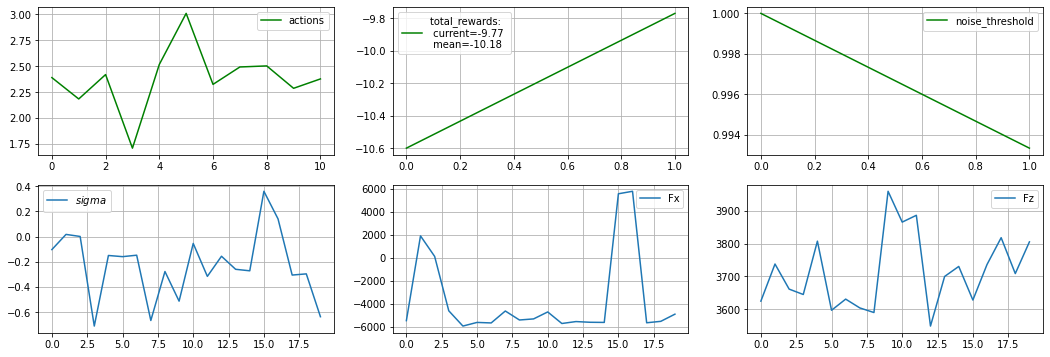

In [25]:
env = ArrivalCarSpeed(dt=1, inner_dt=0.1)

pi_model = SequentialNetwork([env.state_dim, 128, env.action_dim], nn.ReLU(), nn.Tanh())
noise = UniformNoise(env.action_dim, threshold_decrease=1/150)
agent = CCEM(env.state_dim, env.action_dim, env.action_min, env.action_max, pi_model, noise, 
             percentile_param=80,  tau=1e-2, pi_model_lr=1e-2, learning_iter_per_fit=16)

visualizer = ArrivalCarVisualizer(waiting_for_show=1)
solver.go(env, agent, episode_n=151, session_n=10, session_len=16, show=visualizer.show)

на представленных рисунках приведены следующие величины: 

* `action` - значение входной управляющей силы, передаваемой на задние колеса.

* `total_reward` - итоговая награда, которую необходимо максимизировать.

* `sigma` - коэффициент продольного скольжения заднего левого колеса.

* `Fz` - вертикальная нагрузка на заднее левое колесо.

* `Fx` - значение тяги заднего левого колеса.

Графики продольной скорости и скорости вращения переднего левого и заднего левого колес

[array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([6.49966529, 0.        , 0.        , 0.        , 0.        ,
        0.25092877, 0.25092877, 1.00017686, 1.00017686]),
 array([10.26869604,  0.        ,  0.        ,  0.        ,  0.        ,
         0.10682486,  0.10682486,  0.31001994,  0.31001994]),
 array([16.33448387,  0.        ,  0.        ,  0.        ,  0.        ,
         0.31326782,  0.31326782,  0.67522447,  0.67522447]),
 array([23.56719763,  0.        ,  0.        ,  0.        ,  0.        ,
         0.43210131,  0.43210131,  0.72402789,  0.72402789]),
 array([25.40798143,  0.        ,  0.        ,  0.        ,  0.        ,
         0.53537951,  0.53537951,  0.98356684,  0.98356684]),
 array([31.79379791,  0.        ,  0.        ,  0.        ,  0.        ,
         0.71577151,  0.71577151,  1.43266476,  1.43266476]),
 array([35.19958705,  0.        ,  0.        ,  0.        ,  0.        ,
         0.82880001,  0.82880001,  1.47022317,  1.47022317]),
 array([41.7155616

(0.0, 8.5)

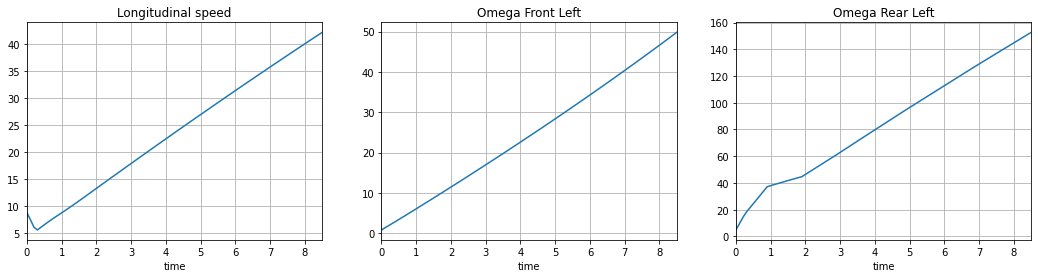

In [79]:
state = np.array(visualizer.session)

time = np.array(range(len(state[:,0])))*0.1

plt.figure(figsize=[18, 4])

plt.subplot(1, 3, 1)
plt.plot(time, state[:,0])
plt.grid()
plt.title('Longitudinal speed')
plt.xlabel('time')
plt.xlim([0, time[-1]])

plt.subplot(1, 3, 2)
plt.plot(time, state[:,5])
plt.grid()
plt.title('Omega Front Left')
plt.xlabel('time')
plt.xlim([0, time[-1]])

plt.subplot(1, 3, 3)
plt.plot(time, state[:,7])
plt.grid()
plt.title('Omega Rear Left')
plt.xlabel('time')
plt.xlim([0, time[-1]])

In [77]:
time[-1]

8.5

График зависимости продольной силы от коэффициента скольжения

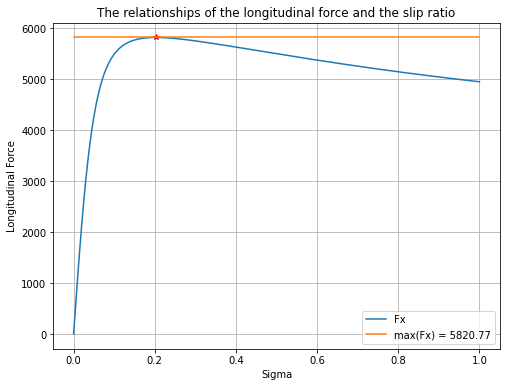

In [8]:
env = ArrivalCar(dt=1, inner_dt=0.25)
mu_road = 1
alpha = 0.0
fz = 3726.805
sigmas = np.linspace(0, 1, 1001)
forces = []

for sigma in sigmas:
    fx, _ = env.dynamics.pacejka.get(mu_road, alpha, sigma, 2, fz, 1)
    forces.append(fx)

plt.figure(figsize=(8, 6))
plt.plot(sigmas,forces, label='Fx')
plt.plot(sigmas[np.argmax(forces)],max(forces), c='Red', marker = '*')
plt.plot([0, 1],[max(forces), max(forces)], label=f'max(Fx) = {round(max(forces),2)}')
plt.title('The relationships of the longitudinal force and the slip ratio')
plt.xlabel('sigma')
plt.ylabel('Longitudinal Force')
plt.grid()
plt.legend()